<a href="https://colab.research.google.com/github/evanstaffen/Melanoma-Identification-with-Convolutinal-Neural-Networks/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma Identification with CNNs
![Melanoma statistics](https://user-images.githubusercontent.com/113449546/206875921-e3fca595-13f7-41e3-9236-613555065715.jpg)

### Business Understanding
Skin cancer is the most common form of cancer in the United States. There are an estimated 9,500+ new diagnoses per day in the United States with an optimistic 99% cure rate. There are three types of skin cancer, Basal Cell Carcinomas (BCCs), Squamous Cell Carcinomas (SCCs) and Melanomas. Although all 3 must be surgically removed, BCCs and SCCs have slim to no chance of being fatal. Melanoma is the only form that has the capability to metastasize throughout the body and has a high probability of being lethal if not discovered early enough.

![8211-Skin_Cancer-_Facts_Statistics_and_You-1296x1270-Infographic-5](https://user-images.githubusercontent.com/113449546/206876845-59adf0c7-6f1b-4de2-b83d-4f9111612840.jpeg) 

![image](https://user-images.githubusercontent.com/113449546/206876294-217e3e37-f5a2-45bb-9e99-838fccd4a350.png)

While there are the basic ABCDE rules for identifying Melanoma, they do not encompass their complexity and diversity in presentation, and can even appear like a regular mole. Dermatologists use Dermatoscopes for better clinical evaluation and advise patients with increased risk of Melanomas to go to MoleSafe, where a full-body 3D scan evaluates all lesions on your body and can be used as a clinical aide. MoleSafe has been an incredible advancement in the treatment of skin cancer as doctors do not have to solely rely on their own eyes to properly diagnose. Although, giving a Dermatologist similar capabilities in the exam room would only lead to earlier detection of Melanoma and therefore improved patient outcomes. 

### **Stakeholder: Dermatoscope manufaturers**

Although MoleSafe has plenty of benefits, it is time-consuming and expensive (~$500) for a personal scan as insurance does not cover it. I set out to create a neural network that could do the same evaluation as MoleSafe, but to be used inside a Dermatoscope while the doctor is in the room with the patient. The doctor would then have a live version of MoleSafe to be used as a clinical aide in their diagnosis. 
<img width="473" alt="Screen Shot 2022-12-10 at 4 51 17 PM" src="https://user-images.githubusercontent.com/113449546/206876611-9f3bde54-2f20-4f9c-b730-e2e4ef94b681.png">


# Imports and Reading in Dataframes

In [2]:
from sklearn.metrics import plot_confusion_matrix
from tensorflow.math import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
from tensorflow.keras.utils import img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall as Recall
from keras import models, layers, optimizers
from keras.callbacks import EarlyStopping
import os
import shutil
from tensorflow.keras.utils import to_categorical

In [ ]:
truth = pd.read_csv('drive/MyDrive/Moles/Data/ISIC_2019_Training_GroundTruth.csv').drop('UNK',axis=1)
metadata = pd.read_csv('drive/MyDrive/Moles/Data/ISIC_2019_Training_Metadata.csv').drop('lesion_id',axis=1)
display('Truth: ', truth.head(),'MetaData: ', metadata.head())

'Truth: '

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'MetaData: '

,image,age_approx,anatom_site_general,sex
0,ISIC_0000000,55.0,anterior torso,female
1,ISIC_0000001,30.0,anterior torso,female
2,ISIC_0000002,60.0,upper extremity,female
3,ISIC_0000003,30.0,upper extremity,male
4,ISIC_0000004,80.0,posterior torso,male


# Preprocessing and EDA

In [ ]:
display('Truth: ', truth.isna().sum(),'Meta: ', metadata.isna().sum())

'Truth: '

image    0
MEL      0
NV       0
BCC      0
AK       0
BKL      0
DF       0
VASC     0
SCC      0
dtype: int64

'Meta: '

image                     0
age_approx              437
anatom_site_general    2631
sex                     384
dtype: int64

In [ ]:
# Check to make sure they have same length before merging
len(truth) == len(metadata)

True

In [ ]:
 # Merging dataframes on image column
 merged_df = pd.merge(truth,metadata,how='inner',on = 'image')
 merged_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,age_approx,anatom_site_general,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,anterior torso,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,anterior torso,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,upper extremity,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,upper extremity,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,posterior torso,male
...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,85.0,head/neck,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,65.0,anterior torso,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,lower extremity,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,palms/soles,female


In [ ]:
# Sanity check to make sure merge was sucessful
# Missing information is only in demographic data, so we do not need to worry about it
merged_df.isna().sum()

image                     0
MEL                       0
NV                        0
BCC                       0
AK                        0
BKL                       0
DF                        0
VASC                      0
SCC                       0
age_approx              437
anatom_site_general    2631
sex                     384
dtype: int64

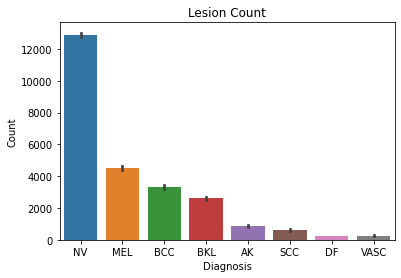

In [ ]:
dx = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC']
plt.figure()
sns.barplot(data=merged_df[dx],estimator=sum,order=['NV','MEL','BCC','BKL','AK','SCC','DF','VASC'])
plt.title('Lesion Count')
plt.xlabel('Diagnosis')
plt.ylabel('Count');

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

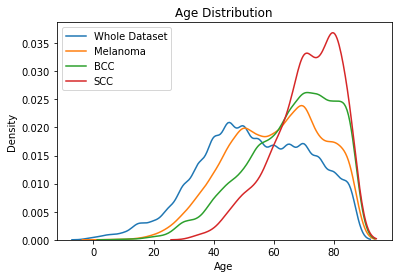

In [ ]:
fig,ax = plt.subplots()

mels = merged_df[merged_df['MEL']==1]
bccs = merged_df[merged_df['BCC']==1]
sccs = merged_df[merged_df['SCC']==1]

sns.distplot(merged_df['age_approx'],hist=False)
sns.distplot(mels['age_approx'],hist=False)
sns.distplot(bccs['age_approx'],hist=False)
sns.distplot(sccs['age_approx'],hist=False)
plt.xlabel('Age')
plt.title('Age Distribution')
plt.legend(['Whole Dataset','Melanoma','BCC','SCC']);

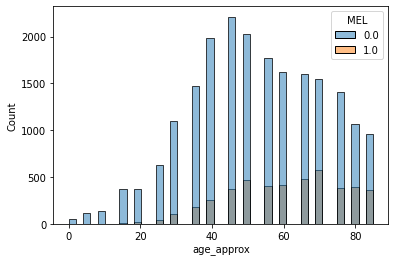

In [ ]:
sns.histplot(merged_df,x='age_approx',hue='MEL')
#sns.histplot(merged_df,x='age_approx',hue='BCC')
#sns.histplot(merged_df,x='age_approx',hue='SCC')

In [ ]:
dx_sex = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','sex']
sns.histplot(merged_df[dx_sex],x='sex',multiple='stack',hue=merged_df[dx])
#sns.histplot(mels,x='sex',color='r')
#sns.histplot(bccs,x='sex',color='g')
#sns.histplot(sccs,x='sex',color='m')
plt.title('Diagnoses by Sex')
plt.xlabel('Sex')
plt.legend(['Whole Dataset','Melanoma','BCCs','SCCs'])
;

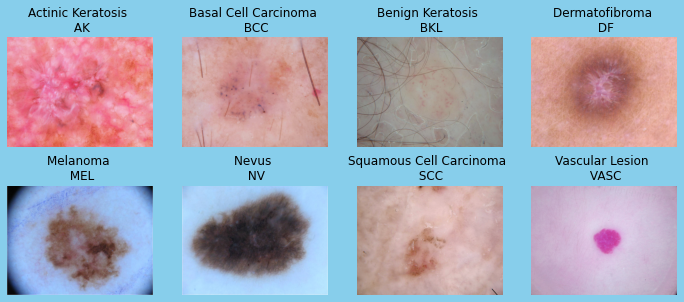

In [ ]:
img_ak = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/AK/ISIC_0024468.jpg')
img_bcc = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/BCC/ISIC_0024331.jpg')
img_bkl = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/BKL/ISIC_0010491.jpg')
img_df = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/DF/ISIC_0024318.jpg')
img_mel = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000002.jpg')
img_nv = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000000.jpg')
img_scc = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/SCC/ISIC_0024329.jpg')
img_vasc = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/VASC/ISIC_0024402.jpg')

f, axarr = plt.subplots(2,4,figsize=(12,5))
axarr[0,0].imshow(img_ak)
axarr[0,0].axis('off')
axarr[0,0].set_title("Actinic Keratosis \n AK")

axarr[0,1].imshow(img_bcc)
axarr[0,1].axis('off')
axarr[0,1].set_title("Basal Cell Carcinoma \n BCC")

axarr[0,2].imshow(img_bkl)
axarr[0,2].axis('off')
axarr[0,2].set_title("Benign Keratosis \n BKL")

axarr[0,3].imshow(img_df)
axarr[0,3].axis('off')
axarr[0,3].set_title("Dermatofibroma \n DF")

axarr[1,0].imshow(img_mel)
axarr[1,0].axis('off')
axarr[1,0].set_title("Melanoma \n MEL")

axarr[1,1].imshow(img_nv)
axarr[1,1].axis('off')
axarr[1,1].set_title("Nevus \n NV")

axarr[1,2].imshow(img_scc)
axarr[1,2].axis('off')
axarr[1,2].set_title("Squamous Cell Carcinoma \n SCC")

axarr[1,3].imshow(img_vasc)
axarr[1,3].axis('off')
axarr[1,3].set_title("Vascular Lesion \n VASC")
f.set_facecolor(color='skyblue')
plt.savefig('/content/drive/MyDrive/Moles/Photos/Skin_Cancers.jpg');

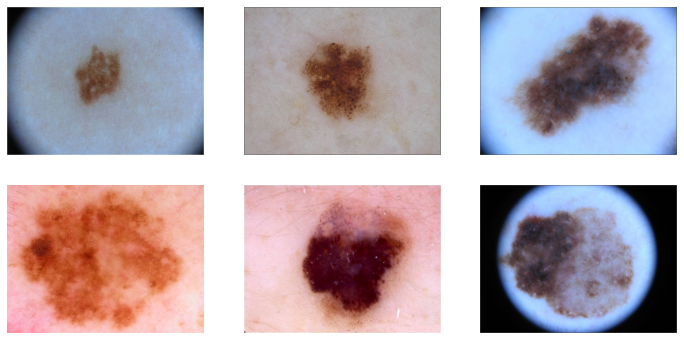

In [12]:
f, axarr = plt.subplots(2,3,figsize=(12,6))

nev_1 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000006.jpg')
nev_2 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000017_downsampled.jpg')
nev_3 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000037_downsampled.jpg')
mel_1 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000279.jpg')
mel_2 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000159.jpg')
mel_3 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000036_downsampled.jpg')

axarr[0,0].imshow(nev_1)
axarr[0,0].axis('off')

axarr[0,1].imshow(nev_2)
axarr[0,1].axis('off')

axarr[0,2].imshow(nev_3)
axarr[0,2].axis('off')

axarr[1,0].imshow(mel_1)
axarr[1,0].axis('off')

axarr[1,1].imshow(mel_2)
axarr[1,1].axis('off')

axarr[1,2].imshow(mel_3)
axarr[1,2].axis('off')

plt.savefig('/content/drive/MyDrive/Moles/Photos/Mole v Mel.jpg');

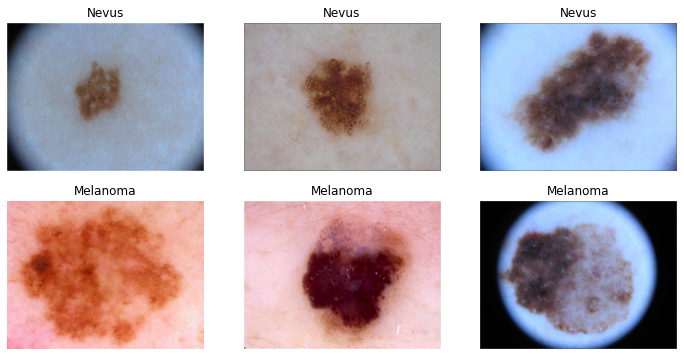

In [17]:
### With titles
f, axarr = plt.subplots(2,3,figsize=(12,6))

nev_1 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000006.jpg')
nev_2 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000017_downsampled.jpg')
nev_3 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/NV/ISIC_0000037_downsampled.jpg')
mel_1 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000279.jpg')
mel_2 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000159.jpg')
mel_3 = mpimg.imread('/content/drive/MyDrive/Moles/Training_Photos/MEL/ISIC_0000036_downsampled.jpg')

axarr[0,0].imshow(nev_1)
axarr[0,0].axis('off')
axarr[0,0].set_title('Nevus')

axarr[0,1].imshow(nev_2)
axarr[0,1].axis('off')
axarr[0,1].set_title('Nevus')

axarr[0,2].imshow(nev_3)
axarr[0,2].axis('off')
axarr[0,2].set_title('Nevus')

axarr[1,0].imshow(mel_1)
axarr[1,0].axis('off')
axarr[1,0].set_title('Melanoma')

axarr[1,1].imshow(mel_2)
axarr[1,1].axis('off')
axarr[1,1].set_title('Melanoma')

axarr[1,2].imshow(mel_3)
axarr[1,2].axis('off')
axarr[1,2].set_title('Melanoma')

plt.savefig('/content/drive/MyDrive/Moles/Photos/Mole v Mel w titles.jpg');

# Organizing photos from Kaggle dataset
- Split diagnoses by Melanoma and Nevus and split into train, validation and testing sets


In [ ]:
#Making folder for each diagnosis
#for x in dx:
  #os.makedirs(f'/content/drive/MyDrive/Moles/Training_Photos/{x}')
  #os.makedirs(f'/content/drive/MyDrive/Moles/Testing_Photos/{x}')
  #os.makedirs(f'/content/drive/MyDrive/Moles/Validation_Photos/{x}')


In [ ]:
#Train, Validation, Test
#test = truth.apply(lambda x: x.sample(frac=0.2,random_state=0))
#train = truth.drop(test.index)
#val = train.apply(lambda x: x.sample(frac=0.1,random_state=0))
#train = train.drop(val.index)

In [ ]:
# Loop through train and test
# Find each row where dx = 1, use image title to move photo from photos folder to designated dx folder
#for i, row in train.iterrows():
#  for x in dx:
#    if row[x] == 1:
#      title = row['image']
#      shutil.move(f'/content/drive/MyDrive/Moles/Photos/{title}.jpg',f'/content/drive/MyDrive/Moles/Training_Photos/{x}')#
#
#for i, row in test.iterrows():
#  for x in dx:
#    if row[x] == 1:
#      title = row['image']
#      shutil.move(f'/content/drive/MyDrive/Moles/Photos/{title}.jpg',f'/content/drive/MyDrive/Moles/Testing_Photos/{x}')
#
#for i, row in val.iterrows():
#  for x in dx:
#    if row[x] == 1:
#      title = row['image']
#      shutil.move(f'/content/drive/MyDrive/Moles/Training_Photos/{x}/{title}.jpg',f'/content/drive/MyDrive/Moles/Validation_Photos/{x}')

In [ ]:
#Use this function as a sanity check
#count = 0
#for root_dir, cur_dir, files in os.walk(r'/content/drive/MyDrive/Moles/Testing_Photos/SCC'):
#    count += len(files)
#print('file count:', count)

file count: 147


In [ ]:
#datagen = ImageDataGenerator(rescale= 1./255
                               #shear_range=0.1,
                               #zoom_range=0.2,
                               #horizontal_flip=True,
                               #fill_mode= 'nearest'
#                               )
                               

#training_generator = datagen.flow_from_directory(
#    '/content/drive/MyDrive/Moles/Training_Photos',
#    target_size=(28, 28),
#    batch_size=18239,
#    color_mode = 'rgb',
#    class_mode='categorical')
                               
#validation_generator = datagen.flow_from_directory(
#    '/content/drive/MyDrive/Moles/Validation_Photos',
#    target_size=(28, 28),
#    batch_size=2026,
#    color_mode = 'rgb',
#    class_mode='categorical')

#testing_generator = datagen.flow_from_directory(
#    '/content/drive/MyDrive/Moles/Testing_Photos',
#    target_size=(28, 28),
#    batch_size=5066,
#    color_mode = 'rgb',
#   class_mode='categorical')

Found 18239 images belonging to 8 classes.
Found 2026 images belonging to 8 classes.
Found 5066 images belonging to 8 classes.


In [ ]:
### Run time == 2.5 hours
#train_images, train_labels = next(training_generator)
#val_images, val_labels = next(validation_generator)
#test_images, test_labels = next(testing_generator)

In [ ]:
#train_images.shape, train_labels.shape

((18239, 28, 28, 3), (18239, 8))

In [ ]:
#Saving arrays
#with open(f'/content/drive/MyDrive/Moles/Arrays/train_images_arrays.npy', 'wb') as f:
#  np.save(f, train_images)
#with open(f'/content/drive/MyDrive/Moles/Arrays/val_images_arrays.npy', 'wb') as f:
#  np.save(f, val_images)
#with open(f'/content/drive/MyDrive/Moles/Arrays/test_images_arrays.npy', 'wb') as f:
#  np.save(f, test_images)

#Saving label arrays
#with open('/content/drive/MyDrive/Moles/Arrays/train_label_arrays.npy', 'wb') as f:
#  np.save(f, train_labels)
#with open('/content/drive/MyDrive/Moles/Arrays/val_label_arrays.npy', 'wb') as f:
#  np.save(f, val_labels)
#with open('/content/drive/MyDrive/Moles/Arrays/test_label_arrays.npy', 'wb') as f:
#  np.save(f, test_labels)

In [ ]:
#Use this function as a sanity check
count = 0
dif_files = ['Training_Photos/NV','Testing_Photos/NV','Validation_Photos/NV','Training_Photos/MEL','Testing_Photos/MEL','Validation_Photos/MEL']
for dif in dif_files:
  for root_dir, cur_dir, files in os.walk(f'/content/drive/MyDrive/Moles/{dif}'):
    count += len(files)
    print(dif, 'file count:', count)
    count = 0

Training_Photos/NV file count: 9371
Testing_Photos/NV file count: 2480
Validation_Photos/NV file count: 1024
Training_Photos/MEL file count: 3259
Testing_Photos/MEL file count: 905
Validation_Photos/MEL file count: 358
